In [1]:
from ocpy.ddp import DDPSolver
from ocpy.ocp import OCP
from ocpy import symutils
import numpy as np
import sympy as sym
from sympy import sin, cos, tan, exp, log, ln, sinh, cosh, tanh, diff, sqrt

# import warnings
# warnings.filterwarnings('error')


In [2]:
# dimensions of state and input
n_x = 4
n_u = 1
sim_name = 'cartpole'
# define ocp class
ocp = OCP(n_x, n_u, sim_name)
# get symbols
t = ocp.get_t()
x = ocp.get_x()
u = ocp.get_u()

In [3]:
# symbolic expressions of constants.
m_c, m_p, l, g, u_min, u_max, u_eps = ocp.define_scalar_constants(
         [('m_c', 2), ('m_p', 0.1), ('l', 0.5), ('g', 9.80665), 
          ('u_min', -15),  ('u_max', 15), ('u_eps', 0.001)]
          )
# cost weight
q = ocp.define_vector_constant('q', [2.5, 10, 0.01, 0.01])
r = ocp.define_vector_constant('r', [1])
q_f = ocp.define_vector_constant('q_f', [2.5, 10, 0.01, 0.01])
Q = sym.diag(*q)
Qf = sym.diag(*q_f)
R = sym.diag(*r)
# reference state. 
x_ref = ocp.define_vector_constant('x_ref', [0, np.pi, 0, 0])


In [4]:
# state of equation.
f = ocp.zero_vector(n_x)
f[0] = x[2]
f[1] = x[3]
f[2] = (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1]) )
f[3] = (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) 
        - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))
# log barrier for control limits.
u_barrier = sum(-ln(u[i] - u_min) - ln(u_max - u[i]) for i in range(n_u)) * 1e-5
# stage cost and terminal cost.
l = (x - x_ref).T * Q * (x - x_ref) + u.T * R * u + sym.Matrix([u_barrier])
lf = (x - x_ref).T * Qf * (x - x_ref) * 10
# display state equation and cost function
display(f)
display(l)
display(lf)


Matrix([
[                                                                                                        x[2]],
[                                                                                                        x[3]],
[                                   (m_p*(g*cos(x[1]) + l*x[1]**2)*sin(x[1]) + u[0])/(m_c + m_p*sin(x[1])**2)],
[(-g*(m_c + m_p)*sin(x[1]) - l*m_p*x[1]**2*sin(x[1])*cos(x[1]) - u[0]*cos(x[1]))/(l*(m_c + m_p*sin(x[1])**2))]])

Matrix([[q[0]*(x[0] - x_ref[0])**2 + q[1]*(x[1] - x_ref[1])**2 + q[2]*(x[2] - x_ref[2])**2 + q[3]*(x[3] - x_ref[3])**2 + r[0]*u[0]**2 - 1.0e-5*log(-u[0] + u_max) - 1.0e-5*log(u[0] - u_min)]])

Matrix([[10*q_f[0]*(x[0] - x_ref[0])**2 + 10*q_f[1]*(x[1] - x_ref[1])**2 + 10*q_f[2]*(x[2] - x_ref[2])**2 + 10*q_f[3]*(x[3] - x_ref[3])**2]])

In [5]:
# horizon length and discretization grids.
T = 5.0
N = 200
# initial condition
t0 = 0.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])
us_guess = np.zeros((N, n_u))
# define ocp
ocp.define(f, l, lf, T, N, t0, x0, us_guess, True, False)


In [6]:

M = sym.Matrix(np.ones((2, 3), dtype=float))
M[0, 0] = x[0] #+ u[0]
Mx = symutils.diff_matrix(M, x)
Mx2 = symutils.diff_matrix_2(M, x)
display(Mx, Mx.shape)
display(Mx2, Mx2.shape)
display(M)

x_array = sym.MutableDenseNDimArray(x.T)[0]
u_array = sym.MutableDenseNDimArray(u.T)[0]

# fx = symutils.diff_vector(f, x)
# # fx = sym.Matrix(np.ones((4, 4), dtype=float))
# display('fx', fx)
# fxx = symutils.diff_matrix(fx, x)
# display('fxx', fxx)
Mx = sym.diff(M, x.T)
Mu = sym.diff(M, u.T)

display('Mx:', Mx.shape, Mx)
display('Mu:', Mu.shape, Mu)


[[[1, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]]

(4, 2, 3)

[[[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]

(2, 3, 4)

Matrix([
[x[0], 1.0, 1.0],
[ 1.0, 1.0, 1.0]])

'Mx:'

(1, 4, 2, 3)

[[[[1, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]]]

'Mu:'

(1, 1, 2, 3)

[[[[0, 0, 0], [0, 0, 0]]]]

In [7]:
df, dl = ocp.get_symbolic_derivatives()
fu = df[2]
fux = df[4]
fuu = df[5]
display(fux.shape)
display(fuu.shape)
display(fuu)

(4, 4, 1)

(1, 4, 1)

[[[0], [0], [0], [0]]]

In [8]:
# hand over ocp to solver.
solver = DDPSolver(ocp)

iter: 0
DeltaV:  -954.6388177522075
iter: 1
DeltaV:  -32800.64701953175
iter: 2
DeltaV:  -2187.664091511846
iter: 3


<lambdifygenerated-7>:4: RuntimeWarning: invalid value encountered in log
  return 0.00025*Dummy_78**2 + 0.00025*Dummy_79**2 + 0.0625*Dummy_81**2 + 0.025*Dummy_82**2 + 2.46740110027234*(0.318309886183791*Dummy_80 - 1)**2 - 2.5e-7*log(15 - Dummy_82) - 2.5e-7*log(Dummy_82 + 15)
<lambdifygenerated-7>:4: RuntimeWarning: overflow encountered in scalar power
  return 0.00025*Dummy_78**2 + 0.00025*Dummy_79**2 + 0.0625*Dummy_81**2 + 0.025*Dummy_82**2 + 2.46740110027234*(0.318309886183791*Dummy_80 - 1)**2 - 2.5e-7*log(15 - Dummy_82) - 2.5e-7*log(Dummy_82 + 15)
<lambdifygenerated-1>:4: RuntimeWarning: overflow encountered in scalar power
  return numpy.array((0.025*_Dummy_37 + _Dummy_39, 0.025*_Dummy_36 + _Dummy_38, _Dummy_37 + 0.025*(_Dummy_40 + 0.1*(0.5*_Dummy_38**2 + 9.80665*cos(_Dummy_38))*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2), _Dummy_36 + 0.05*(-0.05*_Dummy_38**2*sin(_Dummy_38)*cos(_Dummy_38) - _Dummy_40*cos(_Dummy_38) - 20.593965*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2)))
/home/oh

DeltaV:  -99889.21374291464
iter: 4
DeltaV:  -79868.04823796045
iter: 5
DeltaV:  -75080.1226867491


<lambdifygenerated-1>:4: RuntimeWarning: invalid value encountered in scalar add
  return numpy.array((0.025*_Dummy_37 + _Dummy_39, 0.025*_Dummy_36 + _Dummy_38, _Dummy_37 + 0.025*(_Dummy_40 + 0.1*(0.5*_Dummy_38**2 + 9.80665*cos(_Dummy_38))*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2), _Dummy_36 + 0.05*(-0.05*_Dummy_38**2*sin(_Dummy_38)*cos(_Dummy_38) - _Dummy_40*cos(_Dummy_38) - 20.593965*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2)))
<lambdifygenerated-1>:4: RuntimeWarning: invalid value encountered in scalar subtract
  return numpy.array((0.025*_Dummy_37 + _Dummy_39, 0.025*_Dummy_36 + _Dummy_38, _Dummy_37 + 0.025*(_Dummy_40 + 0.1*(0.5*_Dummy_38**2 + 9.80665*cos(_Dummy_38))*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2), _Dummy_36 + 0.05*(-0.05*_Dummy_38**2*sin(_Dummy_38)*cos(_Dummy_38) - _Dummy_40*cos(_Dummy_38) - 20.593965*sin(_Dummy_38))/(0.1*sin(_Dummy_38)**2 + 2)))


iter: 6
DeltaV:  -2239.406802905032
iter: 7
DeltaV:  -200.72302783317807
iter: 8
DeltaV:  -186.86730755412776
iter: 9
DeltaV:  -231.31689756993927
iter: 10
DeltaV:  -589.70111744026
iter: 11
DeltaV:  -147488.51737093495
iter: 12
DeltaV:  -2520.309735183453
iter: 13
DeltaV:  -1804.7157682145137
iter: 14
DeltaV:  -245.67362246030746
iter: 15
DeltaV:  -147.7326847257277
iter: 16
DeltaV:  -43.596174688849786
iter: 17
DeltaV:  -16.821959407051462
iter: 18
DeltaV:  -16.122082494846072
iter: 19
DeltaV:  -8.070539892384135
iter: 20
DeltaV:  -4.6344915136395946
iter: 21
DeltaV:  -4.375363495907467
iter: 22
DeltaV:  -7.580783348041357
iter: 23
DeltaV:  -10.399343551301817
iter: 24
DeltaV:  -4.046278428923658
iter: 25
DeltaV:  -5.659518469823353
iter: 26
DeltaV:  -6.355411796519032
iter: 27
DeltaV:  -22.53504774001876
iter: 28
DeltaV:  -2.5237330628506123
iter: 29
DeltaV:  -2.700479105601096
iter: 30
DeltaV:  -3.1850962848390236
iter: 31
DeltaV:  -2.4275773553525672
iter: 32
DeltaV:  -2.523493895

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Graphs are saved at /home/ohtsukalab/src/ocpy/log/cartpole/result.pdf


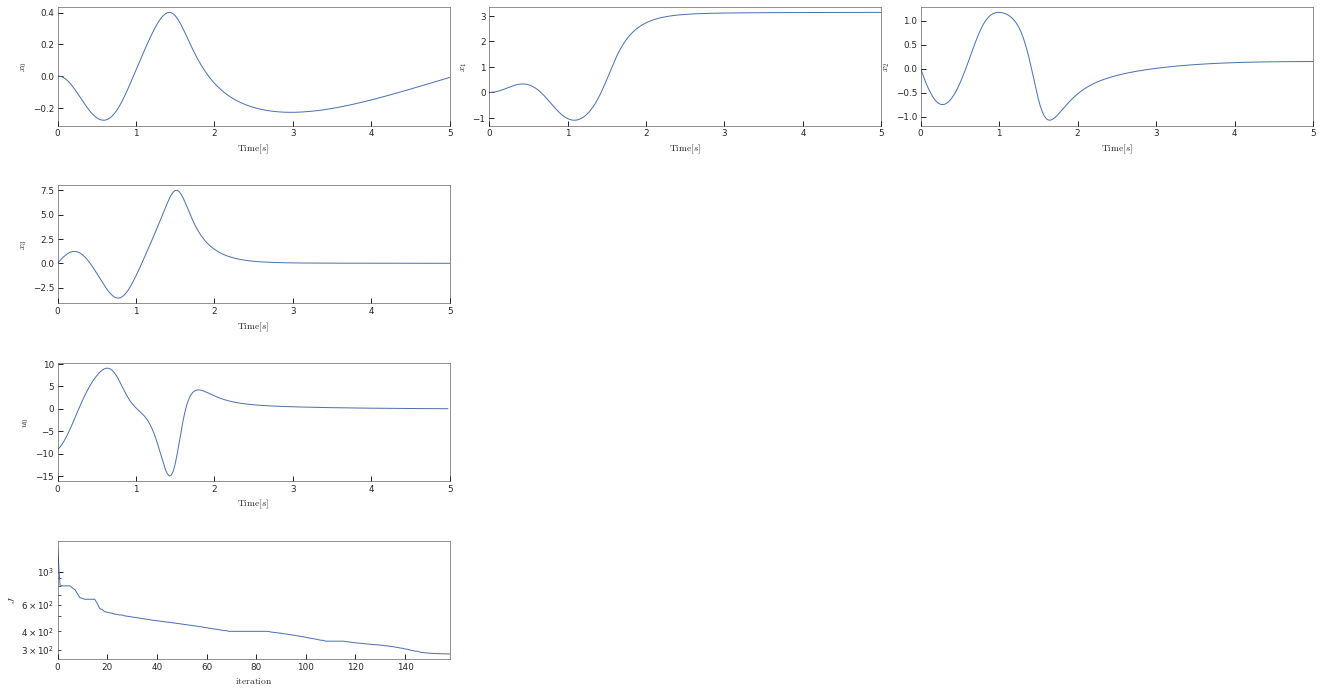

In [9]:
# warnings.filterwarnings('error')
# warnings.resetwarnings()
# candidates of line search steps.
alphas = [0.5**i for i in range(8)].append(0)
# set solver properties.
solver.set_solver_parameters(
    max_iter=300, alphas=alphas, damp_init=1e-3, damp_max=1e4, damp_min=1e-3,
    stop_threshold=1e-1
)
# solve ocpj
ts, xs, us, Js = solver.solve(result= True, log=True)

# damp_fixed = 0
# ts, xs, us, Js = solver.solve(
#     t0, x0, us_guess, max_iter=300, alphas=0.5**np.arange(1) ,
#     damp_init=damp_fixed, damp_min=damp_fixed, damp_max=damp_fixed, result=True, log=True)

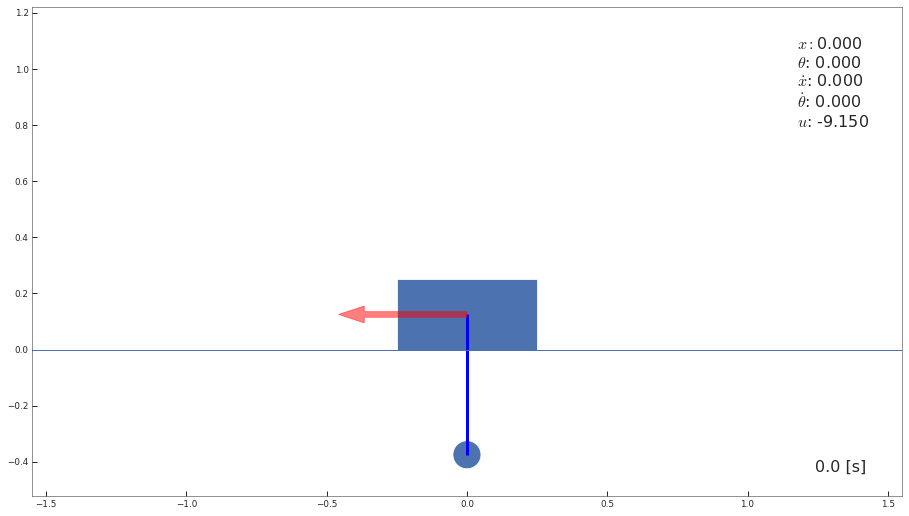

In [10]:
%matplotlib inline
# visualize
from ocpy.animator import CartPoleAnimator
animator = CartPoleAnimator(solver.get_log_directory(), sim_name)
animator.generate_animation(False)


In [11]:
len(Js)


159

In [12]:
Js[-1]

280.7334179115707